In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import dates
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.interpolate as interpolate
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats.mstats import scoreatpercentile
import pyart
import os,subprocess,time,copy
import scipy
import math
import matplotlib.gridspec as gridspec
import cPickle as pickle
#import pickle
import pprint
import pyproj
import scipy.interpolate as interpolate
import datetime
from marcus_py_tools import make_edge_vec,latlon_from_xy,xy_from_latlon,walklevel
%matplotlib inline

#KAZR moment analysis/testing
This notebook covers analysis of calibrated KAZR Doppler spectral moments (corrected by S-band). Note that Z and MDV are likely unreliable (due to Mie effects). So basically this is just to look at spectrum width and estimate error in this variable (mostly error of representativeness). 

In [36]:
filenm = '/home/mvanlier/mvanlier/kazr/sgpkazrspeccmaskgecopolC1.a0.20110520.110007.cdf'
nc = Dataset(filenm,'r')
time = nc.variables['base_time'][:] + nc.variables['time_offset'][:]
zax  = nc.variables['range'][:]
vsig = nc.variables['spectral_width'][:,:]
vavg = nc.variables['mean_doppler_velocity'][:,:]
zdbz = nc.variables['reflectivity'][:,:]
nc.close()
#..

In [94]:
filenm = '/mnt/raid/afridlin/data/mc3e/sband-kazr-williams/sbd_kaz_minute_cal_n5snr_20110520_v20150218.nc'
nc = Dataset(filenm,'r')
zax  = nc.variables['sbd_kaz_range'][:]
#time = (nc.variables['sbd_kaz_time_year'][:]-1970.)*3.15569e7 + 5.*2.63e6
#time += 20.*86400 
#time += nc.variables['sbd_kaz_time_hour'][:]*3600.
#time += nc.variables['sbd_kaz_time_minute'][:]*60.
vsig = nc.variables['kaz_Vsig'][:,:]
vavg = nc.variables['kaz_Vmean'][:,:]
zdbz = nc.variables['kaz_zdb_adjusted'][:,:]
time = np.linspace(11.,16.,num=vsig.shape[0])
nc.close()
#..

In [96]:
print time.shape,vsig.shape

(300,) (300, 250)


In [88]:
filenm = '/mnt/raid/afridlin/data/mc3e/sband-kazr-williams/sbd_kaz_minute_cal_n5snr_20110520_v20150218.nc'
nc = Dataset(filenm,'r')
zax  = nc.variables['sbd_kaz_range'][:]
time = nc.variables['sbd_kaz_time_month'][:]
nc.close()
print time

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

In [79]:
hfmt = dates.DateFormatter('%H:%M')
dts = map(datetime.datetime.utcfromtimestamp,time)
tim = dates.date2num(dts)
#tme = make_edge_vec(tim)

ValueError: timestamp out of range for platform localtime()/gmtime() function

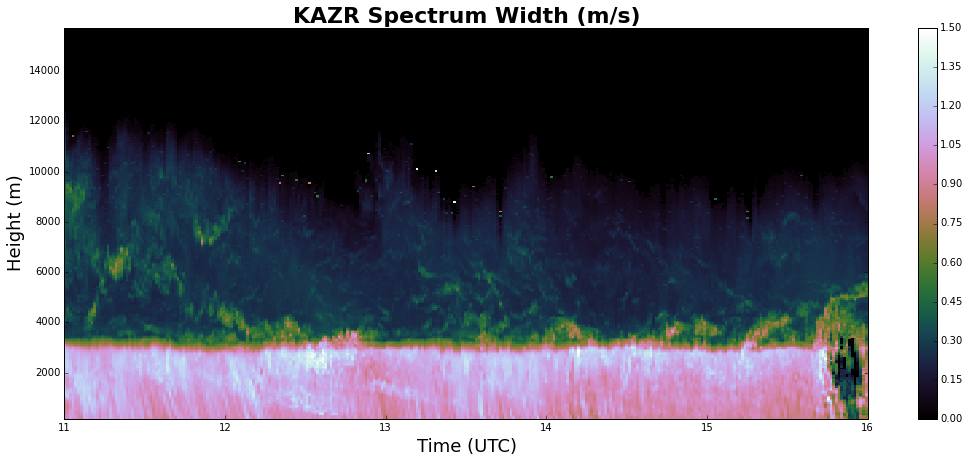

In [98]:
vsig = np.ma.masked_where(np.isnan(vsig),vsig)
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
plt.pcolormesh(time,zax,vsig.T,vmin=0,vmax=1.5,cmap=cm.cubehelix,rasterized=True)
plt.colorbar()
#ax.set_xlim(tim.min(),tim.max())
ax.set_xlim(time.min(),time.max())
ax.set_ylim(zax.min(),zax.max())
#ax.xaxis.set_major_locator(dates.MinuteLocator(interval=10))
#ax.xaxis.set_major_formatter(hfmt)
ax.set_xlabel('Time (UTC)',fontsize=18)
ax.set_ylabel('Height (m)',fontsize=18)
plt.title('KAZR Spectrum Width (m/s)',fontsize=22,fontweight='bold')
plt.savefig('vsig_test.pdf')

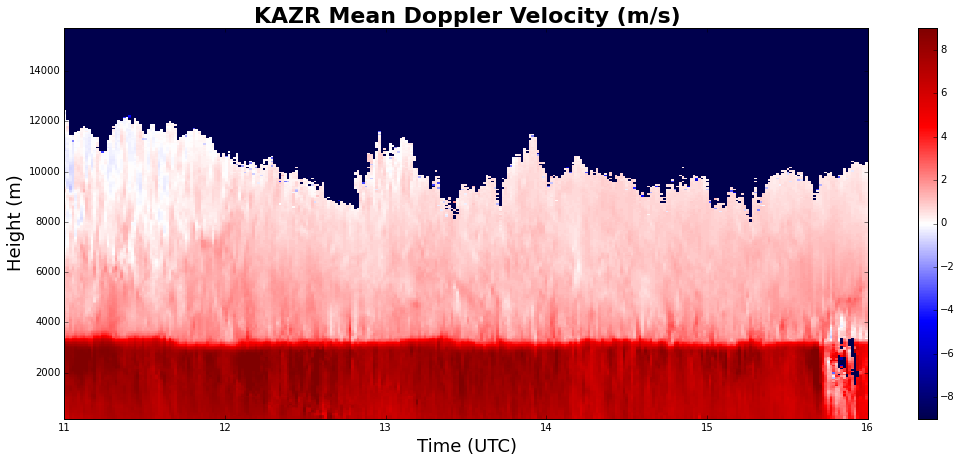

In [99]:
vavg = np.ma.masked_where(np.isnan(vavg),vavg)
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
plt.pcolormesh(time,zax,vavg.T,vmin=-9.,vmax=9.,cmap=cm.seismic,rasterized=True)
plt.colorbar()
ax.set_xlim(time.min(),time.max())
ax.set_ylim(zax.min(),zax.max())
#ax.xaxis.set_major_locator(dates.MinuteLocator(interval=10))
#ax.xaxis.set_major_formatter(hfmt)
ax.set_xlabel('Time (UTC)',fontsize=18)
ax.set_ylabel('Height (m)',fontsize=18)
plt.title('KAZR Mean Doppler Velocity (m/s)',fontsize=22,fontweight='bold')
plt.savefig('vavg_test.pdf')

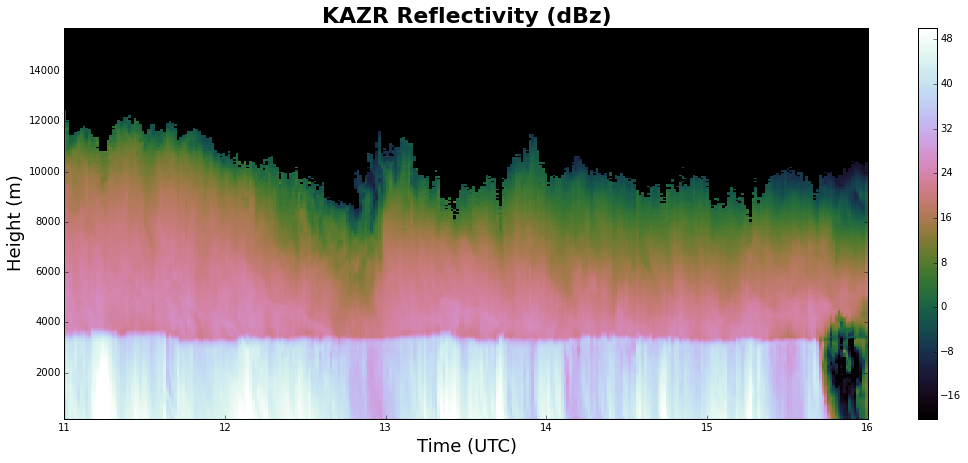

In [101]:
zdbz = np.ma.masked_where(np.isnan(zdbz),zdbz)
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
plt.pcolormesh(time,zax,zdbz.T,vmin=-20.,vmax=50.,cmap=cm.cubehelix,rasterized=True)
plt.colorbar()
ax.set_xlim(time.min(),time.max())
ax.set_ylim(zax.min(),zax.max())
#ax.xaxis.set_major_locator(dates.MinuteLocator(interval=10))
#ax.xaxis.set_major_formatter(hfmt)
ax.set_xlabel('Time (UTC)',fontsize=18)
ax.set_ylabel('Height (m)',fontsize=18)
plt.title('KAZR Reflectivity (dBz)',fontsize=22,fontweight='bold')
plt.savefig('zbdz_test.pdf')

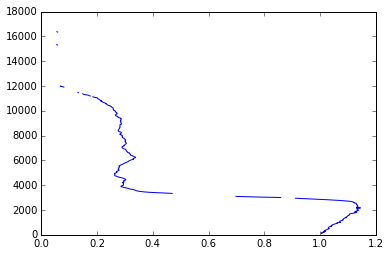

In [32]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
plt.plot(np.ma.mean(vsig,axis=0),zax)

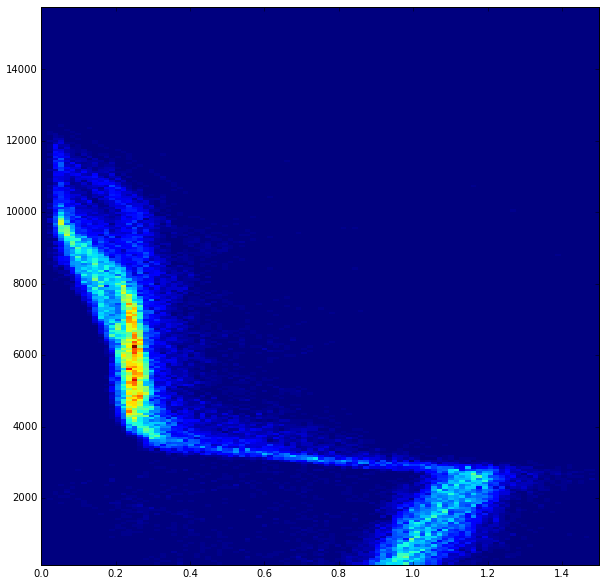

In [104]:
fig=plt.figure(figsize=(10,10))
b = plt.hist2d(vsig.compressed(),zgrid.compressed(),(np.linspace(0,1.5,num=100),zedge))

In [52]:
print vsig.shape,zax.shape

(974, 582) (582,)


In [102]:
zgrid = np.tile(zax,(vsig.shape[0],1))
zgrid = np.ma.masked_where(vsig.mask,zgrid)

In [103]:
zedge = make_edge_vec(zax)

##Attenuation-correction & MDV alignment of KAZR spectra
Using attenuation-corrected moments to adjust raw KAZR spectra, as well as possible. This is probably better for Christopher Williams to try to do, but I will do it anyway to save time

In [9]:
ts_sgp = 20.46    #..11.04
te_sgp = 20.52    #..12.48
#..
tsh_sgp = 24.*(ts_sgp-20)
teh_sgp = 24.*(te_sgp-20)

In [29]:
#..Start with just times from 11.04 onward
raw_filenm1 = '/home/mvanlier/mvanlier/kazr/sgpkazrspeccmaskgecopolC1.a0.20110520.110007.cdf'
nc = Dataset(raw_filenm1,'r')
time = nc.variables['base_time'][:] + nc.variables['time_offset'][:]
zax  = nc.variables['range'][:]
vd   = nc.variables['velocity_bins'][:]
vsig = nc.variables['spectral_width'][:,:]
vavg = nc.variables['mean_doppler_velocity'][:,:]
zdbz = nc.variables['reflectivity'][:,:]
nc.close()
#raw_filenm2 = '
t_hr   = (time - 1305849600.)/3600.
st_idx = np.argmin(abs(t_hr-tsh_sgp))
vde = make_edge_vec(vd)
ze  = make_edge_vec(zax)

In [22]:
t_idx = np.argmin(abs(t_hr-11.6))

584


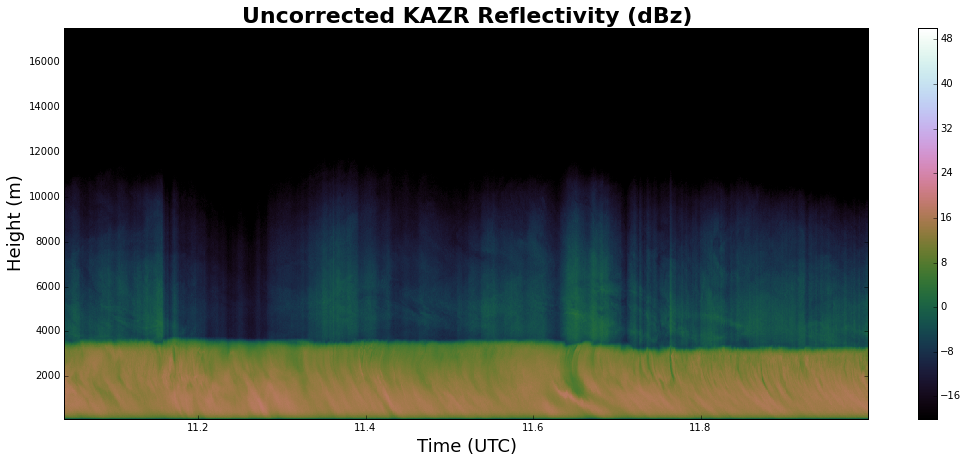

In [20]:
zdbz = np.ma.masked_where(np.isnan(zdbz),zdbz)
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
plt.pcolormesh(t_hr[st_idx:],zax,zdbz[st_idx:,:].T,vmin=-20.,vmax=50.,cmap=cm.cubehelix,rasterized=True)
plt.colorbar()
ax.set_xlim(t_hr[st_idx:].min(),t_hr.max())
ax.set_ylim(zax.min(),zax.max())
#ax.xaxis.set_major_locator(dates.MinuteLocator(interval=10))
#ax.xaxis.set_major_formatter(hfmt)
ax.set_xlabel('Time (UTC)',fontsize=18)
ax.set_ylabel('Height (m)',fontsize=18)
plt.title('Uncorrected KAZR Reflectivity (dBz)',fontsize=22,fontweight='bold')
plt.savefig('zbdz_test.pdf')

In [210]:
#..Let's look at the uncorrected spectrum, why don't we... say at 11.6 aka index # 584
t_idx = np.argmin(abs(t_hr-11.6))
nc = Dataset(raw_filenm1,'r')
loc_mask = nc.variables['locator_mask'][:,:]   #..(time,range)
spec = np.zeros((zax.shape[0],vd.shape[0]))
for i in range(zax.shape[0]):
    if (loc_mask[t_idx,i]==-9999 or loc_mask.mask[t_idx,i]):
        spec[i,:] = -100.
    else:
        spec[i,:] = nc.variables['spectra'][loc_mask[t_idx,i],:]
nc.close
print spec.shape

(582, 256)


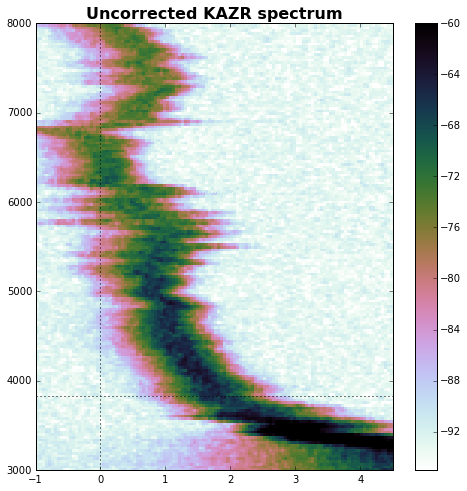

In [211]:
fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111)
#im1 = ax2.pcolormesh(-vde,ze,spec,cmap=cm.cubehelix_r,rasterized=True)
im1 = ax2.pcolormesh(-vde,ze,spec,vmin=-95,vmax=-60.,cmap=cm.cubehelix_r,rasterized=True)
ax2.plot([0.,0.],[0.,ze[-1]],'k:')
ax2.plot([-1,5.5],[4144-320,4144-320],'k:')
#ax2.plot(mdv,zc,'.8',lw=2)
#ax2.scatter(fwd_mdv,zc,c='w',edgecolor='none',alpha=.6)
ax2.set_xlim(-1,4.5)
ax2.set_ylim(3000.,8000.)
plt.colorbar(im1)
plt.title('Uncorrected KAZR spectrum',fontsize=16,fontweight='bold')

In [212]:
print zdbz[t_idx,zidx_ref_kaz],zdbz.shape,zax.shape

-6.50041 (974, 582) (582,)


In [213]:
#..Now use values of  dbz @ 7526.52 from s-band
z_ref = 20.6147766113
zc_ref  = 7526.52
#..Calculate reflectivity offset
zidx_ref_kaz = np.argmin(abs(zax-zc_ref))
ref_cal_off = z_ref - zdbz[t_idx,zidx_ref_kaz]
print ref_cal_off

27.1151881218


In [214]:
#..Convert spectrum from returned power to reflectivity (not sure how, just using log difference as scale factor)
spec_lin    = 10.**(spec/10.)
ref_precal  = 10*np.log10(spec_lin.sum(axis=1)*(vd[3]-vd[2]))
ref_off     = zdbz[t_idx,zidx_ref_kaz] - ref_precal[zidx_ref_kaz]
print ref_off

68.2603722157


In [215]:
#..Now calibrate the raw spectrum from returned power to reflectivity to calibrated reflectivity
spec_lin_cal = spec_lin * (10.**(ref_off/10.) * (10.**(ref_cal_off/10.)))
spec_lin_cal = np.ma.masked_where((spec_lin_cal==0.),spec_lin_cal)
spec_cal = 10.*np.log10(spec_lin_cal)
spec_cal = np.ma.masked_where(np.isnan(spec_cal),spec_cal)
#..Also cacalate reflectivity profile:
ref_cal = 10.*np.log10((vd[3]-vd[2])*(10.**(spec_cal/10.)).sum(axis=1))
ref_cal = np.ma.masked_where(np.isnan(ref_cal),ref_cal)

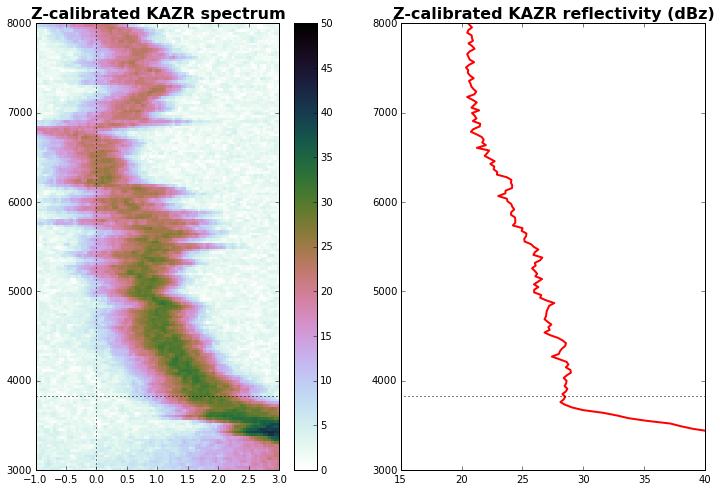

In [216]:
#..Plot calibrated spectrum
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(121)
im1 = ax2.pcolormesh(-vde,ze,spec_cal,vmin=-0,vmax=50,cmap=cm.cubehelix_r,rasterized=True)
#im1 = ax2.pcolormesh(-vde,ze,spec_cal,vmin=-95,vmax=-60.,cmap=cm.cubehelix_r,rasterized=True)
ax2.plot([0.,0.],[0.,ze[-1]],'k:')
ax2.plot([-1,5.5],[4144-320,4144-320],'k:')
#ax2.plot(mdv,zc,'.8',lw=2)
#ax2.scatter(fwd_mdv,zc,c='w',edgecolor='none',alpha=.6)
ax2.set_xlim(-1,3.)
ax2.set_ylim(3000.,8000.)
plt.colorbar(im1)
plt.title('Z-calibrated KAZR spectrum',fontsize=16,fontweight='bold')
ax2 = fig.add_subplot(122)
ax2.plot(ref_cal,zax,'r-',lw=2)
ax2.plot([10,50],[4144-320,4144-320],'k:')
ax2.set_xlim(15.,40.)
ax2.set_ylim(3000.,8000.)
plt.title('Z-calibrated KAZR reflectivity (dBz)',fontsize=16,fontweight='bold')


In [155]:
#..Now cacalate MDV over the entire spectrum set. Note that this should (?) be normalized by the linear
#..reflectivity of the profile, and specifically, the corrected linear reflectivity of the profile... eugh.
#..
#..
#..First things first, lets choose some temporal subsection to make computation tractable & correct relfectivity 
#..profiles according to the mean S-band profiles. 
z_ref = 20.6147766113
zc_ref  = 7526.52
t_beg = 11.4
t_end = 11.6

#..Now let's load the basics.
raw_filenm1 = '/home/mvanlier/mvanlier/kazr/sgpkazrspeccmaskgecopolC1.a0.20110520.110007.cdf'
nc = Dataset(raw_filenm1,'r')
time = nc.variables['base_time'][:] + nc.variables['time_offset'][:]
zax  = nc.variables['range'][:]
vd   = nc.variables['velocity_bins'][:]
vsig = nc.variables['spectral_width'][:,:]
vavg = nc.variables['mean_doppler_velocity'][:,:]
zdbz = nc.variables['reflectivity'][:,:]
nc.close()

#..Cacalate reflectivity offset
ref_cut = 
zidx_ref_kaz = np.argmin(abs(zax-zc_ref))


/home/mvanlier/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


nan